# Week 13 - Day 2: Activation Functions and Loss Functions for Trading

**Date:** January 23, 2026  
**Focus:** Understanding activation functions, loss functions, and their applications in quantitative trading

---

## Learning Objectives

1. Understand common activation functions and their properties
2. Learn standard loss functions (MSE, MAE, Huber, CrossEntropy)
3. Design custom asymmetric loss functions for trading applications
4. Apply these concepts to real SPY market data
5. Consider European market context and regulatory implications

---

## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Financial data
import yfinance as yf

# Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.9.1
Device: cpu


---

## 2. Activation Functions

Activation functions introduce **non-linearity** into neural networks, enabling them to learn complex patterns in financial data.

### Why Non-Linearity Matters in Trading

Financial markets exhibit highly non-linear relationships:
- Volatility clustering
- Regime changes
- Asymmetric responses to news
- Fat-tailed return distributions

Without non-linear activation functions, a neural network would simply be a linear model.

### 2.1 Mathematical Definitions

| Activation | Formula | Range | Derivative |
|------------|---------|-------|------------|
| **ReLU** | $f(x) = \max(0, x)$ | $[0, \infty)$ | $f'(x) = \begin{cases} 1 & x > 0 \\ 0 & x \leq 0 \end{cases}$ |
| **LeakyReLU** | $f(x) = \max(\alpha x, x)$ | $(-\infty, \infty)$ | $f'(x) = \begin{cases} 1 & x > 0 \\ \alpha & x \leq 0 \end{cases}$ |
| **ELU** | $f(x) = \begin{cases} x & x > 0 \\ \alpha(e^x - 1) & x \leq 0 \end{cases}$ | $[-\alpha, \infty)$ | $f'(x) = \begin{cases} 1 & x > 0 \\ f(x) + \alpha & x \leq 0 \end{cases}$ |
| **Tanh** | $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | $f'(x) = 1 - f(x)^2$ |
| **Sigmoid** | $f(x) = \frac{1}{1 + e^{-x}}$ | $(0, 1)$ | $f'(x) = f(x)(1 - f(x))$ |

In [2]:
# Define activation functions for visualization
def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivatives for visualization
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, elu(x, alpha) + alpha)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

### 2.2 Visualization of Activation Functions

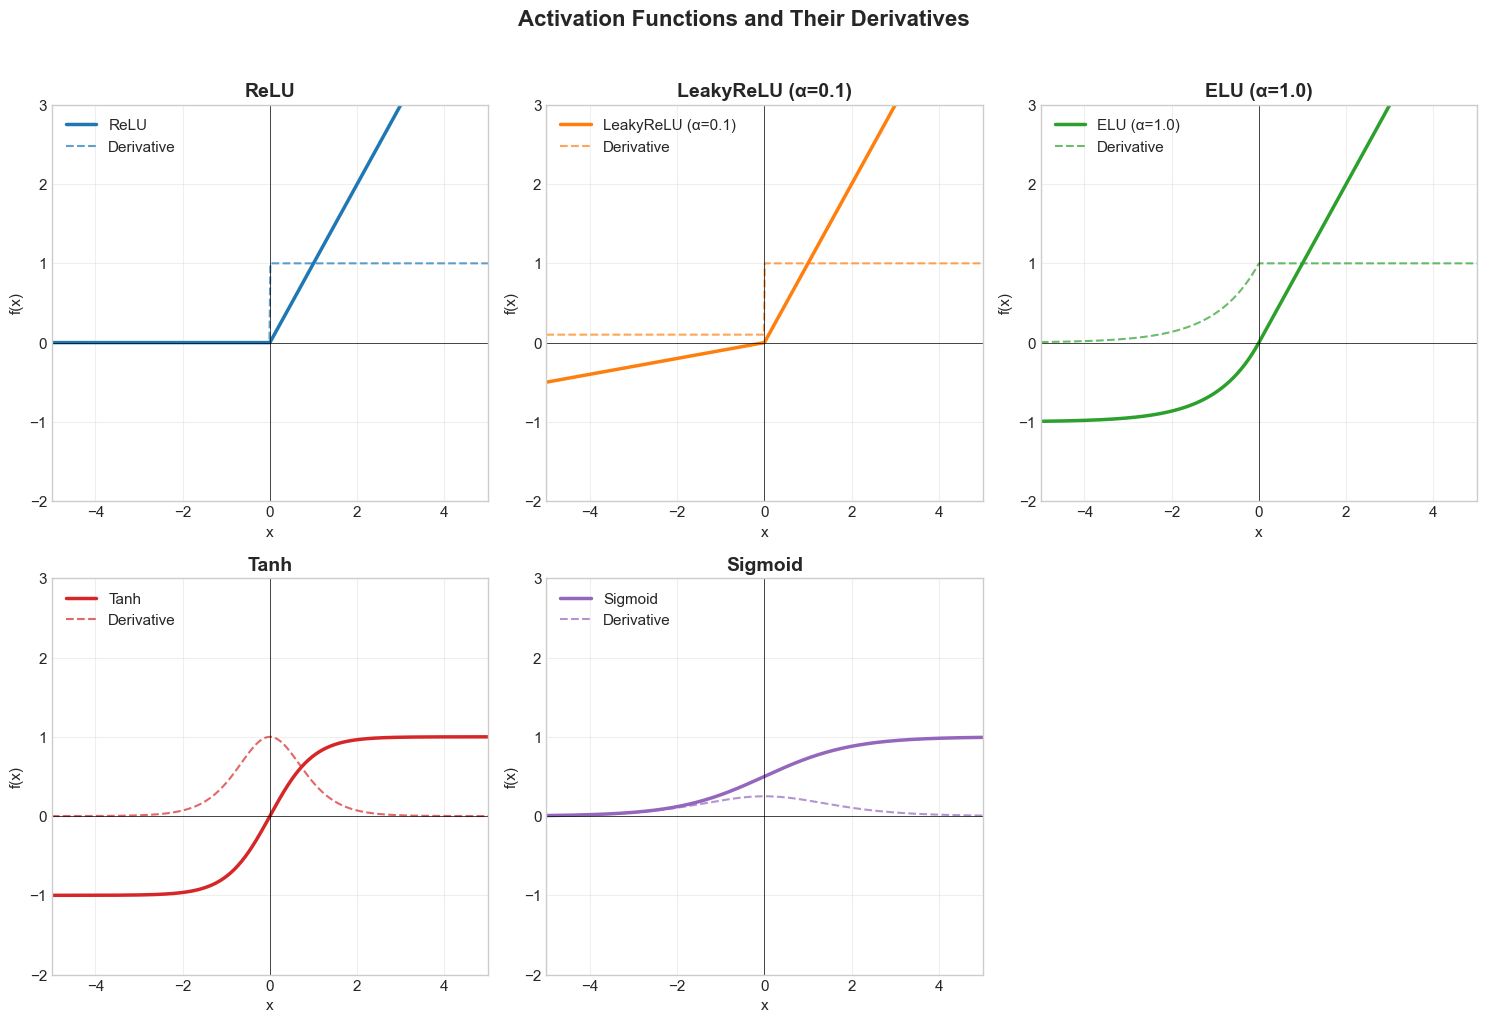

In [3]:
# Create visualization
x = np.linspace(-5, 5, 500)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

activations = [
    ('ReLU', relu, relu_derivative, 'tab:blue'),
    ('LeakyReLU (α=0.1)', lambda x: leaky_relu(x, 0.1), lambda x: leaky_relu_derivative(x, 0.1), 'tab:orange'),
    ('ELU (α=1.0)', elu, elu_derivative, 'tab:green'),
    ('Tanh', tanh, tanh_derivative, 'tab:red'),
    ('Sigmoid', sigmoid, sigmoid_derivative, 'tab:purple'),
]

for idx, (name, func, deriv, color) in enumerate(activations):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    # Plot function and derivative
    ax.plot(x, func(x), color=color, linewidth=2.5, label=f'{name}')
    ax.plot(x, deriv(x), color=color, linewidth=1.5, linestyle='--', alpha=0.7, label='Derivative')
    
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-2, 3)
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[1, 2].axis('off')

plt.suptitle('Activation Functions and Their Derivatives', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.3 Activation Functions in PyTorch

In [4]:
# PyTorch activation functions
x_tensor = torch.linspace(-3, 3, 100)

# Create activation function instances
activations_torch = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(negative_slope=0.1),
    'ELU': nn.ELU(alpha=1.0),
    'Tanh': nn.Tanh(),
    'Sigmoid': nn.Sigmoid(),
    'GELU': nn.GELU(),  # Bonus: Used in Transformers
    'SiLU (Swish)': nn.SiLU(),  # Bonus: Self-gated activation
}

# Display outputs
print("PyTorch Activation Functions Output (for x = [-2, -1, 0, 1, 2]):")
print("=" * 70)

test_values = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])

for name, activation in activations_torch.items():
    output = activation(test_values)
    print(f"{name:15s}: {output.numpy().round(4)}")

PyTorch Activation Functions Output (for x = [-2, -1, 0, 1, 2]):
ReLU           : [0. 0. 0. 1. 2.]
LeakyReLU      : [-0.2 -0.1  0.   1.   2. ]
ELU            : [-0.8647 -0.6321  0.      1.      2.    ]
Tanh           : [-0.964  -0.7616  0.      0.7616  0.964 ]
Sigmoid        : [0.1192 0.2689 0.5    0.7311 0.8808]
GELU           : [-0.0455 -0.1587  0.      0.8413  1.9545]
SiLU (Swish)   : [-0.2384 -0.2689  0.      0.7311  1.7616]


### 2.4 Choosing Activation Functions for Trading

| Use Case | Recommended Activation | Reasoning |
|----------|------------------------|------------|
| **Hidden layers** | ReLU, LeakyReLU, ELU | Fast training, avoid vanishing gradients |
| **Price prediction** | Linear (no activation) | Unbounded output for continuous values |
| **Return direction** | Tanh | Output in [-1, 1] for long/short signals |
| **Probability output** | Sigmoid | Output in [0, 1] for binary classification |
| **Multi-class** | Softmax | Probability distribution over classes |

> **European Context:** Under MiFID II regulations, trading algorithms must be explainable. ReLU-based networks are preferred for their interpretability compared to more complex activations.

---

## 3. Loss Functions

Loss functions quantify the difference between predictions and actual values. The choice of loss function significantly impacts model behavior and trading performance.

### 3.1 Mathematical Definitions

For predictions $\hat{y}_i$ and targets $y_i$ over $n$ samples:

**Mean Squared Error (MSE):**
$$\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Mean Absolute Error (MAE):**
$$\mathcal{L}_{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

**Huber Loss (Smooth L1):**
$$\mathcal{L}_{Huber} = \frac{1}{n} \sum_{i=1}^{n} \begin{cases} 
\frac{1}{2}(y_i - \hat{y}_i)^2 & \text{if } |y_i - \hat{y}_i| < \delta \\
\delta |y_i - \hat{y}_i| - \frac{1}{2}\delta^2 & \text{otherwise}
\end{cases}$$

**Binary Cross-Entropy:**
$$\mathcal{L}_{BCE} = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$$

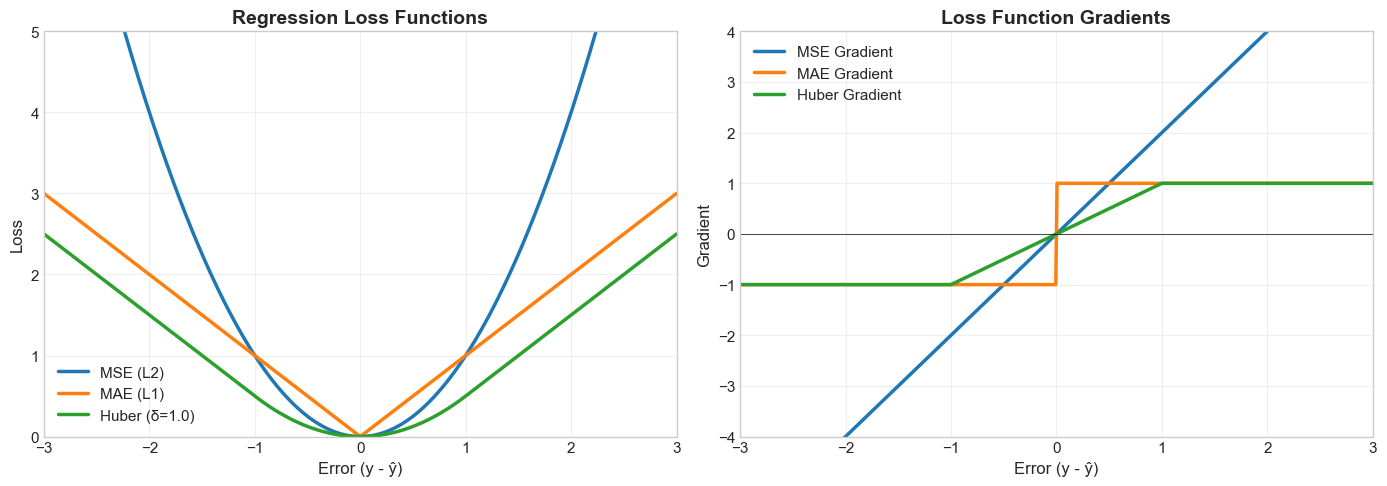

In [5]:
# Visualize loss functions
errors = np.linspace(-3, 3, 500)

# Loss values
mse = errors ** 2
mae = np.abs(errors)

delta = 1.0
huber = np.where(np.abs(errors) < delta, 
                 0.5 * errors**2, 
                 delta * np.abs(errors) - 0.5 * delta**2)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss functions
ax1 = axes[0]
ax1.plot(errors, mse, label='MSE (L2)', linewidth=2.5, color='tab:blue')
ax1.plot(errors, mae, label='MAE (L1)', linewidth=2.5, color='tab:orange')
ax1.plot(errors, huber, label=f'Huber (δ={delta})', linewidth=2.5, color='tab:green')
ax1.set_xlabel('Error (y - ŷ)', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Regression Loss Functions', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.set_xlim(-3, 3)
ax1.set_ylim(0, 5)
ax1.grid(True, alpha=0.3)

# Gradients
ax2 = axes[1]
mse_grad = 2 * errors
mae_grad = np.sign(errors)
huber_grad = np.where(np.abs(errors) < delta, errors, delta * np.sign(errors))

ax2.plot(errors, mse_grad, label='MSE Gradient', linewidth=2.5, color='tab:blue')
ax2.plot(errors, mae_grad, label='MAE Gradient', linewidth=2.5, color='tab:orange')
ax2.plot(errors, huber_grad, label='Huber Gradient', linewidth=2.5, color='tab:green')
ax2.set_xlabel('Error (y - ŷ)', fontsize=12)
ax2.set_ylabel('Gradient', fontsize=12)
ax2.set_title('Loss Function Gradients', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.set_xlim(-3, 3)
ax2.set_ylim(-4, 4)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 PyTorch Loss Functions

In [6]:
# PyTorch loss functions demonstration
y_true = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = torch.tensor([1.2, 1.8, 3.5, 3.8, 5.2])

# Regression losses
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
huber_loss = nn.HuberLoss(delta=1.0)
smooth_l1 = nn.SmoothL1Loss()

print("Regression Loss Functions:")
print("=" * 50)
print(f"MSE Loss:       {mse_loss(y_pred, y_true).item():.6f}")
print(f"MAE Loss:       {mae_loss(y_pred, y_true).item():.6f}")
print(f"Huber Loss:     {huber_loss(y_pred, y_true).item():.6f}")
print(f"Smooth L1 Loss: {smooth_l1(y_pred, y_true).item():.6f}")

print("\n" + "=" * 50)
print("\nClassification Loss Functions:")
print("=" * 50)

# Binary classification
y_true_binary = torch.tensor([1.0, 0.0, 1.0, 1.0, 0.0])
y_pred_proba = torch.tensor([0.9, 0.2, 0.8, 0.7, 0.3])

bce_loss = nn.BCELoss()
bce_logits = nn.BCEWithLogitsLoss()

print(f"BCE Loss:       {bce_loss(y_pred_proba, y_true_binary).item():.6f}")

# Multi-class classification
y_true_class = torch.tensor([0, 2, 1])  # Class indices
y_pred_logits = torch.tensor([[2.0, 0.5, 0.3],
                              [0.1, 0.2, 2.5],
                              [0.3, 1.8, 0.4]])

ce_loss = nn.CrossEntropyLoss()
print(f"CrossEntropy:   {ce_loss(y_pred_logits, y_true_class).item():.6f}")

Regression Loss Functions:
MSE Loss:       0.082000
MAE Loss:       0.260000
Huber Loss:     0.041000
Smooth L1 Loss: 0.041000


Classification Loss Functions:
BCE Loss:       0.252999
CrossEntropy:   0.300156


### 3.3 Loss Function Selection for Trading

| Task | Recommended Loss | Why |
|------|------------------|-----|
| **Price prediction** | Huber / MSE | Balance between outlier robustness and accuracy |
| **Return prediction** | MAE / Huber | More robust to extreme returns |
| **Direction prediction** | BCE / CrossEntropy | Probabilistic interpretation |
| **Volatility forecasting** | MSE | Penalize large forecast errors heavily |
| **Risk-adjusted returns** | Custom asymmetric | Different penalties for under/over prediction |

---

## 4. Custom Asymmetric Loss Functions for Trading

In trading, prediction errors often have **asymmetric consequences**:
- Missing a rally (opportunity cost) vs. catching a crash (capital preservation)
- Overestimating volatility (excess hedging cost) vs. underestimating (tail risk)

### 4.1 Asymmetric MSE Loss

$$\mathcal{L}_{Asym} = \frac{1}{n} \sum_{i=1}^{n} \begin{cases} 
\alpha (y_i - \hat{y}_i)^2 & \text{if } y_i > \hat{y}_i \text{ (underprediction)} \\
\beta (y_i - \hat{y}_i)^2 & \text{if } y_i \leq \hat{y}_i \text{ (overprediction)}
\end{cases}$$

Where $\alpha > \beta$ penalizes underprediction more heavily (useful for risk management).

In [7]:
class AsymmetricMSELoss(nn.Module):
    """
    Asymmetric MSE Loss for trading applications.
    
    Parameters:
    -----------
    alpha : float
        Weight for underprediction errors (y > y_hat)
    beta : float  
        Weight for overprediction errors (y <= y_hat)
    """
    def __init__(self, alpha=2.0, beta=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
    
    def forward(self, y_pred, y_true):
        errors = y_true - y_pred
        squared_errors = errors ** 2
        
        # Apply asymmetric weights
        weights = torch.where(errors > 0, self.alpha, self.beta)
        weighted_loss = weights * squared_errors
        
        return weighted_loss.mean()


class DirectionalLoss(nn.Module):
    """
    Loss that penalizes wrong direction predictions more heavily.
    Useful for trading where direction matters more than magnitude.
    
    L = MSE + λ * DirectionPenalty
    """
    def __init__(self, direction_weight=1.0):
        super().__init__()
        self.direction_weight = direction_weight
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        # Standard MSE
        mse_loss = self.mse(y_pred, y_true)
        
        # Direction penalty: penalize when signs don't match
        sign_match = torch.sign(y_pred) == torch.sign(y_true)
        direction_penalty = (~sign_match).float().mean()
        
        return mse_loss + self.direction_weight * direction_penalty


class TradingPnLLoss(nn.Module):
    """
    Direct P&L-based loss function.
    Optimizes for actual trading profit rather than prediction accuracy.
    
    Assumes:
    - y_pred: predicted returns (or signals)
    - y_true: actual returns
    - Position taken proportional to prediction
    """
    def __init__(self, transaction_cost=0.001):
        super().__init__()
        self.transaction_cost = transaction_cost
    
    def forward(self, y_pred, y_true):
        # P&L = prediction * actual return (simplified)
        pnl = y_pred * y_true
        
        # Transaction costs (proportional to position changes)
        position_changes = torch.abs(torch.diff(y_pred, dim=0))
        costs = self.transaction_cost * position_changes.sum()
        
        # Negative because we want to maximize P&L (minimize negative P&L)
        return -pnl.mean() + costs


# Test custom losses
print("Custom Loss Functions Test:")
print("=" * 50)

y_true = torch.tensor([0.02, -0.01, 0.03, -0.02, 0.01])
y_pred = torch.tensor([0.01, 0.01, 0.02, -0.01, 0.02])  # Some wrong directions

asym_loss = AsymmetricMSELoss(alpha=2.0, beta=1.0)
dir_loss = DirectionalLoss(direction_weight=0.5)
pnl_loss = TradingPnLLoss(transaction_cost=0.001)

print(f"Asymmetric MSE (α=2, β=1): {asym_loss(y_pred, y_true).item():.6f}")
print(f"Directional Loss:          {dir_loss(y_pred, y_true).item():.6f}")
print(f"Trading P&L Loss:          {pnl_loss(y_pred, y_true).item():.6f}")

Custom Loss Functions Test:
Asymmetric MSE (α=2, β=1): 0.000200
Directional Loss:          0.100160
Trading P&L Loss:          -0.000150


### 4.2 Visualizing Asymmetric Loss

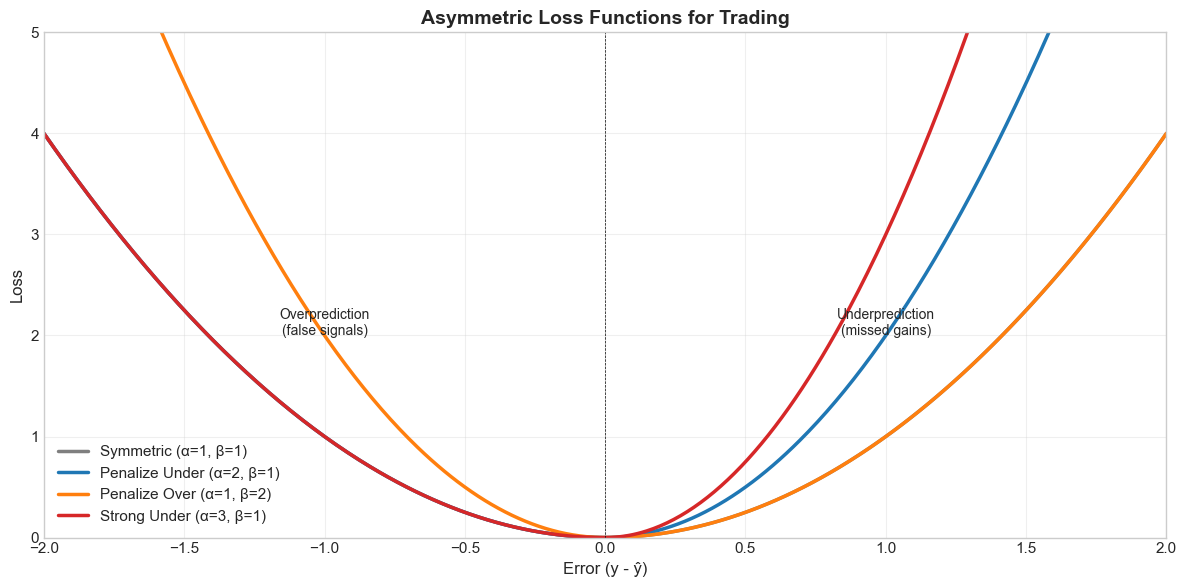

In [8]:
# Visualize asymmetric loss
errors = np.linspace(-2, 2, 500)

# Different asymmetry configurations
configs = [
    (1.0, 1.0, 'Symmetric (α=1, β=1)'),
    (2.0, 1.0, 'Penalize Under (α=2, β=1)'),
    (1.0, 2.0, 'Penalize Over (α=1, β=2)'),
    (3.0, 1.0, 'Strong Under (α=3, β=1)'),
]

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['tab:gray', 'tab:blue', 'tab:orange', 'tab:red']

for (alpha, beta, label), color in zip(configs, colors):
    loss = np.where(errors > 0, alpha * errors**2, beta * errors**2)
    ax.plot(errors, loss, label=label, linewidth=2.5, color=color)

ax.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlabel('Error (y - ŷ)', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Asymmetric Loss Functions for Trading', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Underprediction\n(missed gains)', xy=(1, 2), fontsize=10, ha='center')
ax.annotate('Overprediction\n(false signals)', xy=(-1, 2), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

---

## 5. Practical Application: SPY Return Prediction

Let's apply these concepts to real market data using the S&P 500 ETF (SPY).

### 5.1 Data Loading and Preparation

In [9]:
# Download SPY data
print("Downloading SPY data...")
spy = yf.download('SPY', start='2020-01-01', end='2025-12-31', progress=False)

# Use 'Close' column (not 'Adj Close' as per requirements)
df = pd.DataFrame()
df['Close'] = spy['Close'].squeeze()
df['Volume'] = spy['Volume'].squeeze()
df['High'] = spy['High'].squeeze()
df['Low'] = spy['Low'].squeeze()
df['Open'] = spy['Open'].squeeze()

# Calculate features
df['Returns'] = df['Close'].pct_change()
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Technical indicators as features
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['Volatility_20'] = df['Returns'].rolling(20).std()
df['RSI'] = 100 - (100 / (1 + df['Returns'].rolling(14).apply(
    lambda x: x[x > 0].sum() / abs(x[x < 0].sum()) if abs(x[x < 0].sum()) > 0 else 1)))
df['Price_SMA_Ratio'] = df['Close'] / df['SMA_20']
df['Range'] = (df['High'] - df['Low']) / df['Close']

# Target: Next day's return (for prediction)
df['Target_Return'] = df['Returns'].shift(-1)
df['Target_Direction'] = (df['Target_Return'] > 0).astype(float)

# Drop NaN values
df = df.dropna()

print(f"\nData shape: {df.shape}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nFeature statistics:")
df[['Returns', 'Volatility_20', 'RSI', 'Target_Return']].describe().round(4)


Data shape: (1486, 15)
Date range: 2020-01-31 to 2025-12-29

Feature statistics:


,Returns,Volatility_20,RSI,Target_Return
count,1486.0000,1486.0000,1486.0000,1486.0000
mean,0.0006,0.0110,57.0812,0.0007
std,0.0131,0.0074,15.9364,0.0131
min,-0.1094,0.0034,13.0091,-0.1094
25%,-0.0049,0.0068,45.9508,-0.0049
50%,0.0010,0.0090,58.6729,0.0010
75%,0.0069,0.0125,68.2154,0.0069
max,0.1050,0.0587,96.8118,0.1050


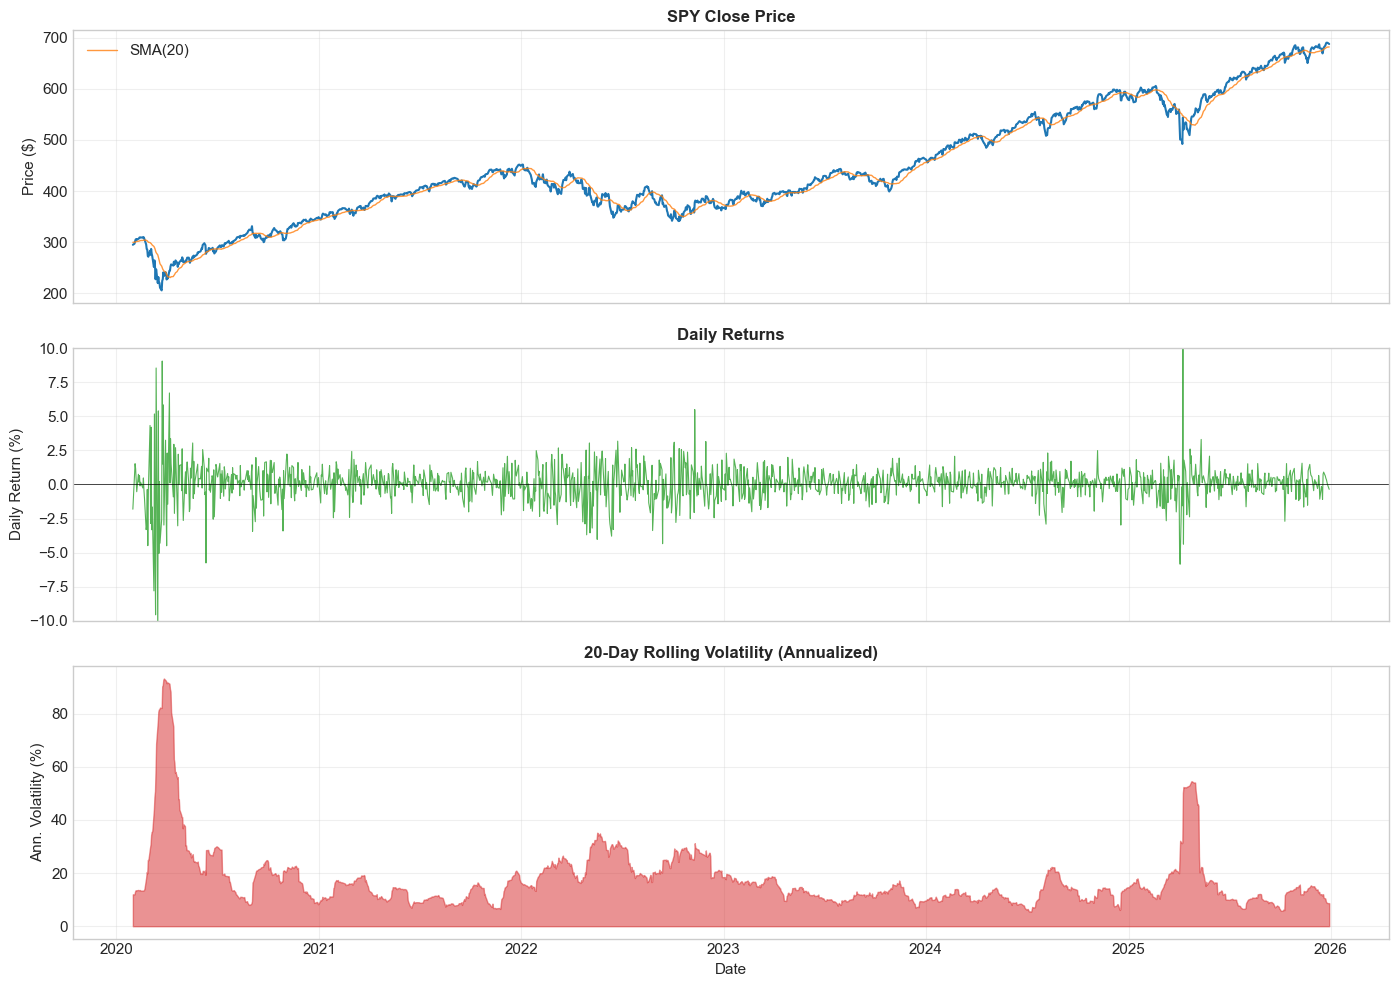

In [10]:
# Visualize SPY data
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price
axes[0].plot(df.index, df['Close'], color='tab:blue', linewidth=1.5)
axes[0].plot(df.index, df['SMA_20'], color='tab:orange', linewidth=1, alpha=0.8, label='SMA(20)')
axes[0].set_ylabel('Price ($)', fontsize=11)
axes[0].set_title('SPY Close Price', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Returns distribution
axes[1].plot(df.index, df['Returns'] * 100, color='tab:green', linewidth=0.8, alpha=0.8)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_ylabel('Daily Return (%)', fontsize=11)
axes[1].set_title('Daily Returns', fontsize=12, fontweight='bold')
axes[1].set_ylim(-10, 10)
axes[1].grid(True, alpha=0.3)

# Rolling volatility
axes[2].fill_between(df.index, 0, df['Volatility_20'] * 100 * np.sqrt(252), 
                     color='tab:red', alpha=0.5)
axes[2].set_ylabel('Ann. Volatility (%)', fontsize=11)
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_title('20-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Neural Network Model Definition

In [11]:
class ReturnPredictor(nn.Module):
    """
    Neural network for predicting stock returns.
    Configurable activation function for experimentation.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], activation='relu', dropout=0.2):
        super().__init__()
        
        # Select activation function
        activation_map = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'silu': nn.SiLU(),
        }
        self.activation = activation_map.get(activation, nn.ReLU())
        
        # Build layers
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                self.activation,
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer (no activation for regression)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze(-1)


# Test model architecture
model_test = ReturnPredictor(input_dim=6, hidden_dims=[64, 32], activation='relu')
print("Model Architecture:")
print(model_test)
print(f"\nTotal parameters: {sum(p.numel() for p in model_test.parameters()):,}")

Model Architecture:
ReturnPredictor(
  (activation): ReLU()
  (network): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 2,753


### 5.3 Data Preparation for PyTorch

In [12]:
# Prepare features and target
feature_cols = ['Returns', 'Volatility_20', 'RSI', 'Price_SMA_Ratio', 'Range', 'Log_Returns']
X = df[feature_cols].values
y = df['Target_Return'].values

# Train/test split (time-based, not random)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")

Training samples: 1188
Test samples: 298
Features: ['Returns', 'Volatility_20', 'RSI', 'Price_SMA_Ratio', 'Range', 'Log_Returns']


### 5.4 Training Function

In [13]:
def train_model(model, train_loader, test_loader, loss_fn, epochs=100, lr=0.001):
    """
    Train the neural network model.
    
    Returns:
    --------
    dict: Training history with losses and metrics
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    history = {'train_loss': [], 'test_loss': [], 'direction_acc': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_losses = []
            all_preds, all_targets = [], []
            
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                test_losses.append(loss_fn(y_pred, y_batch).item())
                all_preds.extend(y_pred.numpy())
                all_targets.extend(y_batch.numpy())
            
            # Direction accuracy
            preds = np.array(all_preds)
            targets = np.array(all_targets)
            direction_acc = (np.sign(preds) == np.sign(targets)).mean()
        
        # Record history
        avg_train_loss = np.mean(train_losses)
        avg_test_loss = np.mean(test_losses)
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['direction_acc'].append(direction_acc)
        
        scheduler.step(avg_test_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.6f} | "
                  f"Test Loss: {avg_test_loss:.6f} | "
                  f"Dir Acc: {direction_acc:.2%}")
    
    return history

### 5.5 Comparing Loss Functions

In [14]:
# Train models with different loss functions
loss_functions = {
    'MSE': nn.MSELoss(),
    'MAE': nn.L1Loss(),
    'Huber': nn.HuberLoss(delta=0.01),
    'Asymmetric': AsymmetricMSELoss(alpha=2.0, beta=1.0),
}

results = {}

for name, loss_fn in loss_functions.items():
    print(f"\n{'='*60}")
    print(f"Training with {name} Loss")
    print('='*60)
    
    # Reset model for fair comparison
    torch.manual_seed(42)
    model = ReturnPredictor(
        input_dim=len(feature_cols), 
        hidden_dims=[64, 32], 
        activation='leaky_relu'
    )
    
    history = train_model(model, train_loader, test_loader, loss_fn, epochs=100)
    results[name] = {
        'history': history,
        'model': model
    }


Training with MSE Loss
Epoch  20/100 | Train Loss: 0.002985 | Test Loss: 0.000278 | Dir Acc: 46.98%
Epoch  40/100 | Train Loss: 0.000448 | Test Loss: 0.000148 | Dir Acc: 46.98%
Epoch  60/100 | Train Loss: 0.000196 | Test Loss: 0.000135 | Dir Acc: 48.99%
Epoch  80/100 | Train Loss: 0.000183 | Test Loss: 0.000131 | Dir Acc: 56.71%
Epoch 100/100 | Train Loss: 0.000187 | Test Loss: 0.000130 | Dir Acc: 55.37%

Training with MAE Loss
Epoch  20/100 | Train Loss: 0.010153 | Test Loss: 0.007522 | Dir Acc: 47.32%
Epoch  40/100 | Train Loss: 0.009096 | Test Loss: 0.007220 | Dir Acc: 54.70%
Epoch  60/100 | Train Loss: 0.008994 | Test Loss: 0.007040 | Dir Acc: 55.37%
Epoch  80/100 | Train Loss: 0.008924 | Test Loss: 0.006999 | Dir Acc: 57.05%
Epoch 100/100 | Train Loss: 0.009036 | Test Loss: 0.007006 | Dir Acc: 57.05%

Training with Huber Loss
Epoch  20/100 | Train Loss: 0.000063 | Test Loss: 0.000041 | Dir Acc: 43.62%
Epoch  40/100 | Train Loss: 0.000056 | Test Loss: 0.000039 | Dir Acc: 48.99%
Ep

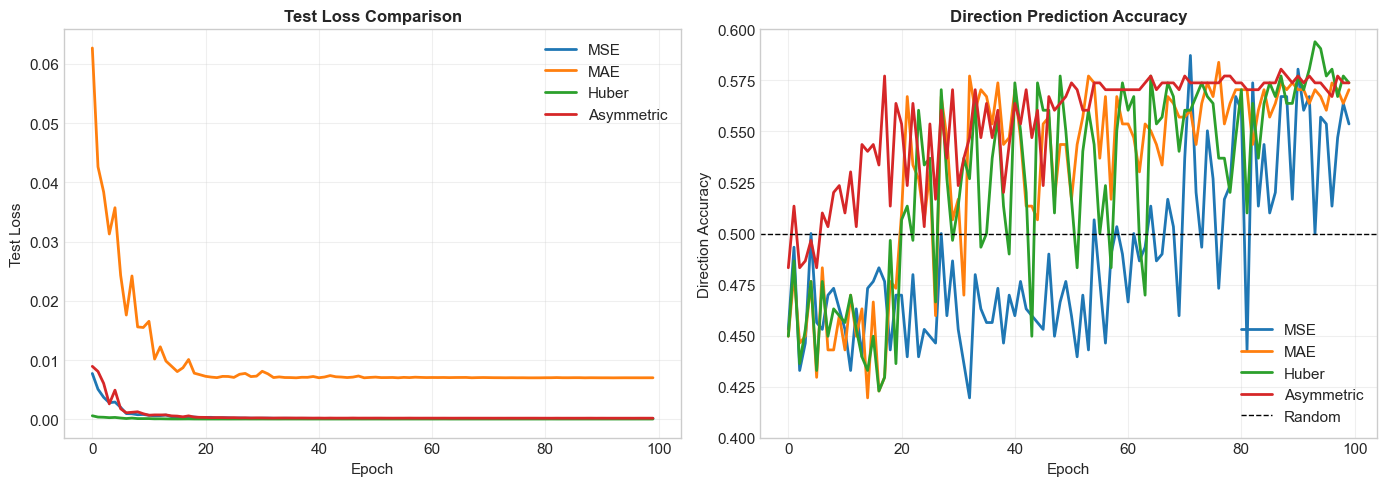

In [15]:
# Visualize training comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Training loss
ax1 = axes[0]
for (name, result), color in zip(results.items(), colors):
    ax1.plot(result['history']['test_loss'], label=name, color=color, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Test Loss', fontsize=11)
ax1.set_title('Test Loss Comparison', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Direction accuracy
ax2 = axes[1]
for (name, result), color in zip(results.items(), colors):
    ax2.plot(result['history']['direction_acc'], label=name, color=color, linewidth=2)
ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Direction Accuracy', fontsize=11)
ax2.set_title('Direction Prediction Accuracy', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.4, 0.6)

plt.tight_layout()
plt.show()

### 5.6 Comparing Activation Functions

In [16]:
# Compare different activation functions
activations_to_test = ['relu', 'leaky_relu', 'elu', 'tanh', 'silu']
activation_results = {}

loss_fn = nn.HuberLoss(delta=0.01)  # Use Huber for all

print("Comparing Activation Functions")
print("="*60)

for activation in activations_to_test:
    torch.manual_seed(42)
    model = ReturnPredictor(
        input_dim=len(feature_cols),
        hidden_dims=[64, 32],
        activation=activation
    )
    
    history = train_model(model, train_loader, test_loader, loss_fn, epochs=80)
    
    final_acc = history['direction_acc'][-1]
    final_loss = history['test_loss'][-1]
    
    activation_results[activation] = {
        'history': history,
        'final_acc': final_acc,
        'final_loss': final_loss
    }
    
    print(f"{activation:12s} | Final Loss: {final_loss:.6f} | Dir Acc: {final_acc:.2%}")

Comparing Activation Functions
Epoch  20/80 | Train Loss: 0.000066 | Test Loss: 0.000043 | Dir Acc: 47.65%
Epoch  40/80 | Train Loss: 0.000057 | Test Loss: 0.000038 | Dir Acc: 52.68%
Epoch  60/80 | Train Loss: 0.000055 | Test Loss: 0.000039 | Dir Acc: 57.05%
Epoch  80/80 | Train Loss: 0.000054 | Test Loss: 0.000037 | Dir Acc: 58.39%
relu         | Final Loss: 0.000037 | Dir Acc: 58.39%
Epoch  20/80 | Train Loss: 0.000063 | Test Loss: 0.000041 | Dir Acc: 43.62%
Epoch  40/80 | Train Loss: 0.000056 | Test Loss: 0.000039 | Dir Acc: 48.99%
Epoch  60/80 | Train Loss: 0.000056 | Test Loss: 0.000039 | Dir Acc: 57.38%
Epoch  80/80 | Train Loss: 0.000055 | Test Loss: 0.000038 | Dir Acc: 54.70%
leaky_relu   | Final Loss: 0.000038 | Dir Acc: 54.70%
Epoch  20/80 | Train Loss: 0.000056 | Test Loss: 0.000039 | Dir Acc: 50.00%
Epoch  40/80 | Train Loss: 0.000056 | Test Loss: 0.000039 | Dir Acc: 51.68%
Epoch  60/80 | Train Loss: 0.000056 | Test Loss: 0.000038 | Dir Acc: 54.03%
Epoch  80/80 | Train Loss

In [17]:
# Summary comparison
summary_data = []
for activation, result in activation_results.items():
    summary_data.append({
        'Activation': activation.upper(),
        'Final Loss': result['final_loss'],
        'Direction Accuracy': result['final_acc'],
        'Max Accuracy': max(result['history']['direction_acc'])
    })

summary_df = pd.DataFrame(summary_data).sort_values('Direction Accuracy', ascending=False)
print("\nActivation Function Comparison Summary:")
print("="*60)
print(summary_df.to_string(index=False))


Activation Function Comparison Summary:
Activation  Final Loss  Direction Accuracy  Max Accuracy
      RELU    0.000037            0.583893      0.583893
       ELU    0.000037            0.573826      0.580537
      SILU    0.000037            0.570470      0.583893
LEAKY_RELU    0.000038            0.546980      0.577181
      TANH    0.000038            0.543624      0.583893


---

## 6. European Market Context

### 6.1 Regulatory Considerations

When deploying ML models in European markets, consider:

**MiFID II Requirements:**
- Algorithm testing and validation documentation
- Real-time monitoring and kill switches
- Model governance and change management

**GDPR Implications:**
- Data handling for alternative data sources
- Model explainability ("right to explanation")

**Market-Specific Considerations:**
- Trading hours: 08:00-16:30 CET (vs US 09:30-16:00 ET)
- Different liquidity patterns
- Circuit breakers and volatility interruptions

In [18]:
# European market example: EuroStoxx 50
print("Downloading European market data (STOXX 50)...")
euro_stoxx = yf.download('^STOXX50E', start='2023-01-01', end='2025-12-31', progress=False)

if len(euro_stoxx) > 0:
    euro_df = pd.DataFrame()
    euro_df['Close'] = euro_stoxx['Close'].squeeze()
    euro_df['Returns'] = euro_df['Close'].pct_change()
    euro_df = euro_df.dropna()
    
    # Compare SPY vs Euro Stoxx volatility
    spy_vol = df['Returns'].std() * np.sqrt(252) * 100
    euro_vol = euro_df['Returns'].std() * np.sqrt(252) * 100
    
    print(f"\nVolatility Comparison (Annualized):")
    print(f"SPY (US):        {spy_vol:.2f}%")
    print(f"Euro Stoxx 50:   {euro_vol:.2f}%")
    print(f"\nNote: Different market dynamics may require adjusted loss function weights.")
else:
    print("Could not download Euro Stoxx data.")


Volatility Comparison (Annualized):
SPY (US):        20.86%
Euro Stoxx 50:   14.88%

Note: Different market dynamics may require adjusted loss function weights.


---

## 7. Key Takeaways

### Activation Functions
1. **ReLU family** (ReLU, LeakyReLU, ELU) are preferred for hidden layers due to efficient training
2. **Tanh** is useful when bounded outputs in [-1, 1] are needed (e.g., position sizing)
3. **Sigmoid** for probability outputs in binary classification
4. **No activation** (linear) for regression output layers

### Loss Functions
1. **MSE** penalizes large errors heavily - good for volatility forecasting
2. **MAE** is more robust to outliers - better for return prediction
3. **Huber** combines benefits of both - often the best default choice
4. **Asymmetric losses** align model training with trading objectives

### Trading-Specific Insights
1. Direction accuracy often matters more than magnitude accuracy
2. Custom loss functions can encode domain knowledge
3. Consider transaction costs in loss function design
4. Regulatory requirements may favor simpler, more interpretable models

---

## 8. Exercises

1. **Implement Quantile Loss:** Create a loss function that predicts different quantiles (e.g., 10th, 50th, 90th percentile) of returns.

2. **Sharpe Ratio Loss:** Design a loss function that directly optimizes for Sharpe ratio rather than prediction accuracy.

3. **Multi-horizon Prediction:** Extend the model to predict returns at multiple horizons (1-day, 5-day, 20-day) with appropriate loss weighting.

4. **Activation Visualization:** Create gradient flow visualizations to understand vanishing gradient problem with Sigmoid vs ReLU.

---

## References

1. Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. *AISTATS*.
2. Huber, P. J. (1964). Robust estimation of a location parameter. *Annals of Statistics*.
3. López de Prado, M. (2018). *Advances in Financial Machine Learning*. Wiley.
4. MiFID II Technical Standards - ESMA Guidelines on algorithmic trading.